首先把训练集读进来简单看看各列的情况，主要看一下预测目标price的情况，发现均值在5900左右，标准差在7500左右，然而最大值居然有99999，可以看出事情不简单，回归题最怕存在离群点...¶

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


train_df = pd.read_csv('./used_car_train_20200313.csv', sep=' ')
train_df.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.0,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,2583.077267,0.000007,0.0,2.016033e+07,5923.327333,44.406268,-0.044809,0.080765,0.078833,0.017875,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,1885.363218,0.002582,0.0,1.067328e+02,7501.998477,2.457548,3.641893,2.929618,2.026514,1.193661,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,2.015062e+07,11.000000,30.451976,-4.295589,-4.470671,-7.275037,-4.364565,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1018.000000,0.000000,0.0,2.016031e+07,1300.000000,43.135799,-3.192349,-0.970671,-1.462580,-0.921191,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,2196.000000,0.000000,0.0,2.016032e+07,3250.000000,44.610266,-3.052671,-0.382947,0.099722,-0.075910,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3843.000000,0.000000,0.0,2.016033e+07,7700.000000,46.004721,4.000670,0.241335,1.565838,0.868758,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,8120.000000,1.000000,0.0,2.016041e+07,99999.000000,52.304178,7.320308,19.035496,9.854702,6.829352,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


直接画图看一下，发现事情确实不简单，这看上去是个不太好预测的分布，跟正态分布相差有一点远，远处的离群点看起来还不少，训练起来误差估计会很大，这些离群点没办法准确预测，训练的时候可以考虑去掉，但如果测试集也有类似的点，那就没办法了，回归场景里面一个离群点带来的误差就能拖垮整个数据集上的指标分数。

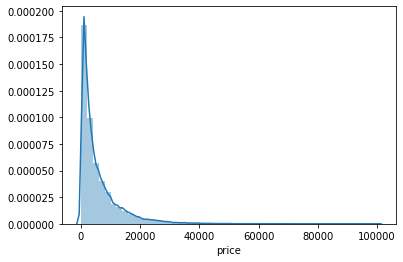

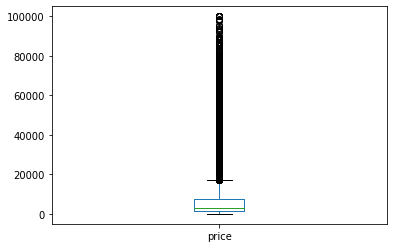

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure()
sns.distplot(train_df['price'])
plt.figure()
train_df['price'].plot.box()
plt.show()

把测试集读进来，看看全数据集的情况

In [3]:
import gc


test_df = pd.read_csv('./used_car_testA_20200313.csv', sep=' ')
print(test_df.shape)
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
del train_df, test_df
gc.collect()
df.head()

(50000, 30)


,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,regDate,regionCode,seller,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,20040402,1046,0,43.357796,3.966344,-2.881803,2.804097,-2.420821,0.795292,0.914762,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,20030301,4366,0,45.305273,5.236112,-4.900482,2.096338,-1.030483,-1.722674,0.245522,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,20040403,2806,0,45.978359,4.823792,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,0,193,2400.0,19960908,434,0,45.687478,4.492574,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,0,68,5200.0,20120103,6977,0,44.383511,2.031433,-1.896240,0.910783,0.931110,2.834518,1.923482,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534


把特征分成三部分，分别是日期特征、类别特征、数值特征。然后看看每一维特征的缺失率、n unique等信息，可以发现seller、offerType这两个特征可以删掉了，所有样本就一个取值，没什么用。从这里还可以发现匿名特征里面的v_0到v_4、v_10到v_14感觉长的有点像，貌似有很多相似的地方。

In [4]:
date_cols = ['regDate', 'creatDate']
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
cols = date_cols + cate_cols + num_cols

tmp = pd.DataFrame()
tmp['count'] = df[cols].count().values
tmp['missing_rate'] = (df.shape[0] - tmp['count']) / df.shape[0]
tmp['nunique'] = df[cols].nunique().values
tmp['max_value_counts'] = [df[f].value_counts().values[0] for f in cols]
tmp['max_value_counts_prop'] = tmp['max_value_counts'] / df.shape[0]
tmp['max_value_counts_value'] = [df[f].value_counts().index[0] for f in cols]
tmp.index = cols
tmp

,count,missing_rate,nunique,max_value_counts,max_value_counts_prop,max_value_counts_value
regDate,200000,0.000000,3900,228,0.001140,20000008
creatDate,200000,0.000000,101,7814,0.039070,20160403
name,200000,0.000000,128466,378,0.001890,708
model,199999,0.000005,248,15658,0.078290,0
brand,200000,0.000000,40,41828,0.209140,0
bodyType,194081,0.029595,8,55405,0.277025,0
fuelType,188427,0.057865,7,122312,0.611560,0
gearbox,192109,0.039455,2,148924,0.744620,0
notRepairedDamage,200000,0.000000,3,148610,0.743050,0.0
regionCode,200000,0.000000,8021,515,0.002575,419


把日期列处理一下，提取年、月、日、星期等信息。这里有些日期异常的样本，月份出现了0，因此需要开个函数单独处理一下。

In [5]:
from tqdm import tqdm


def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


for f in tqdm(date_cols):
    df[f] = pd.to_datetime(df[f].astype('str').apply(date_proc))
    df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    df[f + '_day'] = df[f].dt.day
    df[f + '_dayofweek'] = df[f].dt.dayofweek

100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


然后看一下这些日期相关的特征的分布，可以看出汽车上线时间的年份（creatDate_year）基本上都是2016年，这个特征也没什么用了。creatDate_month基本上只有3、4两个月的，可以暂且保留，

<Figure size 432x288 with 0 Axes>

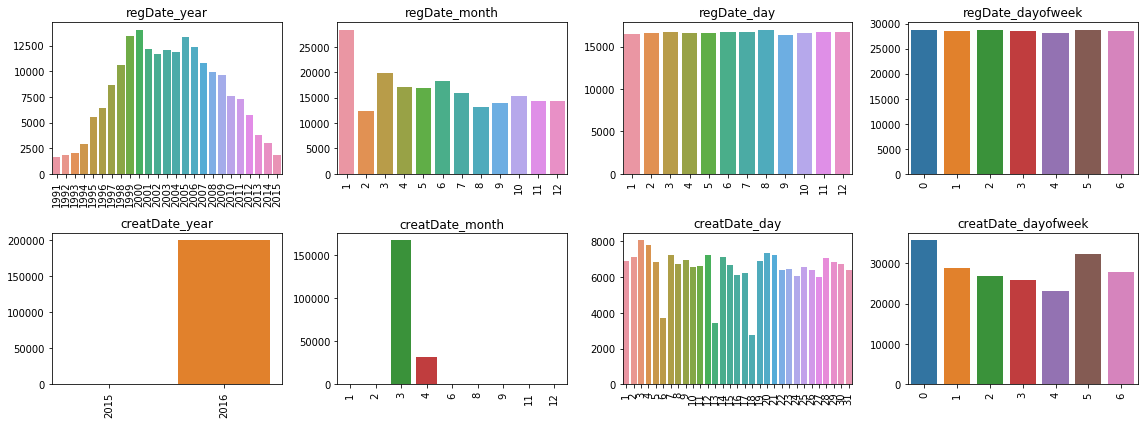

In [6]:
plt.figure()
plt.figure(figsize=(16, 6))
i = 1
for f in date_cols:
    for col in ['year', 'month', 'day', 'dayofweek']:
        plt.subplot(2, 4, i)
        i += 1
        v = df[f + '_' + col].value_counts()
        fig = sns.barplot(x=v.index, y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(f + '_' + col)
plt.tight_layout()
plt.show()

In [7]:
cate_cols.remove('seller')
cate_cols.remove('offerType')
date_cols = ['regDate_year', 'regDate_month', 'regDate_day', 'regDate_dayofweek', 'creatDate_month', 'creatDate_day', 'creatDate_dayofweek']

来看一下各个数值特征跟price的相关性。跟price相关性比较高的有汽车注册年份（regDate_year），应该可以理解为车越新，价格越高；汽车已行驶公里数（kilometer）也还行，应该可以理解为跑的路程越多，车就越旧，价格就越低；匿名特征里面的v_0、v_3、v_8、v_12看起来跟price的相关性很高，原因就不知道了。除了跟price的相关性，还可以发现有些特征跟特征之间的相关性也很高，比如v_1跟v_6、v_2跟v_7、v_3跟v_8、v_4跟v_9等，这些特征之间可能存在冗余现象，训练的时候可以依据效果尝试去掉一部分，或者拆分成两部分，做模型融合

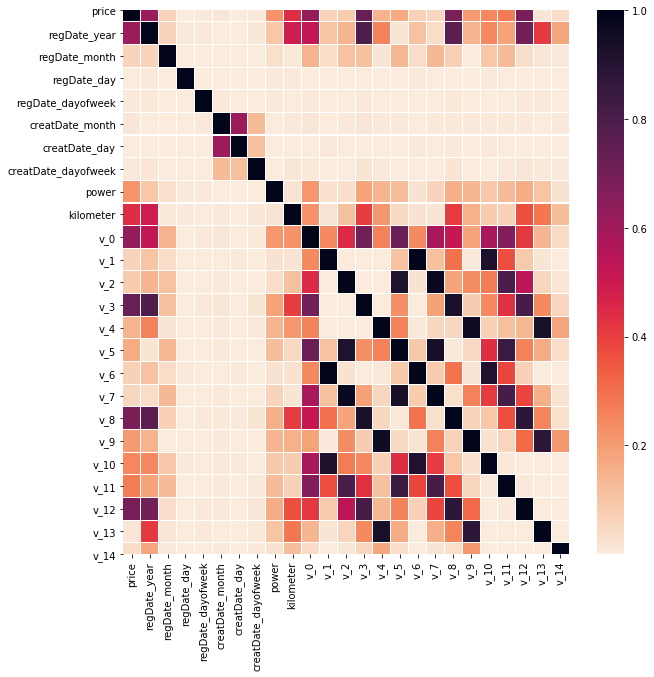

In [8]:
corr1 = abs(df[~df['price'].isnull()][['price'] + date_cols + num_cols].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

接下来看看15维匿名特征分别在训练集和测试集上的分布，如果发现分布不一致的，可以尝试处理。但是貌似这15维特征在训练集和测试集上的分布基本上都挺一致的，无论多奇怪的分布，两个数据集上都挺一致

<Figure size 432x288 with 0 Axes>

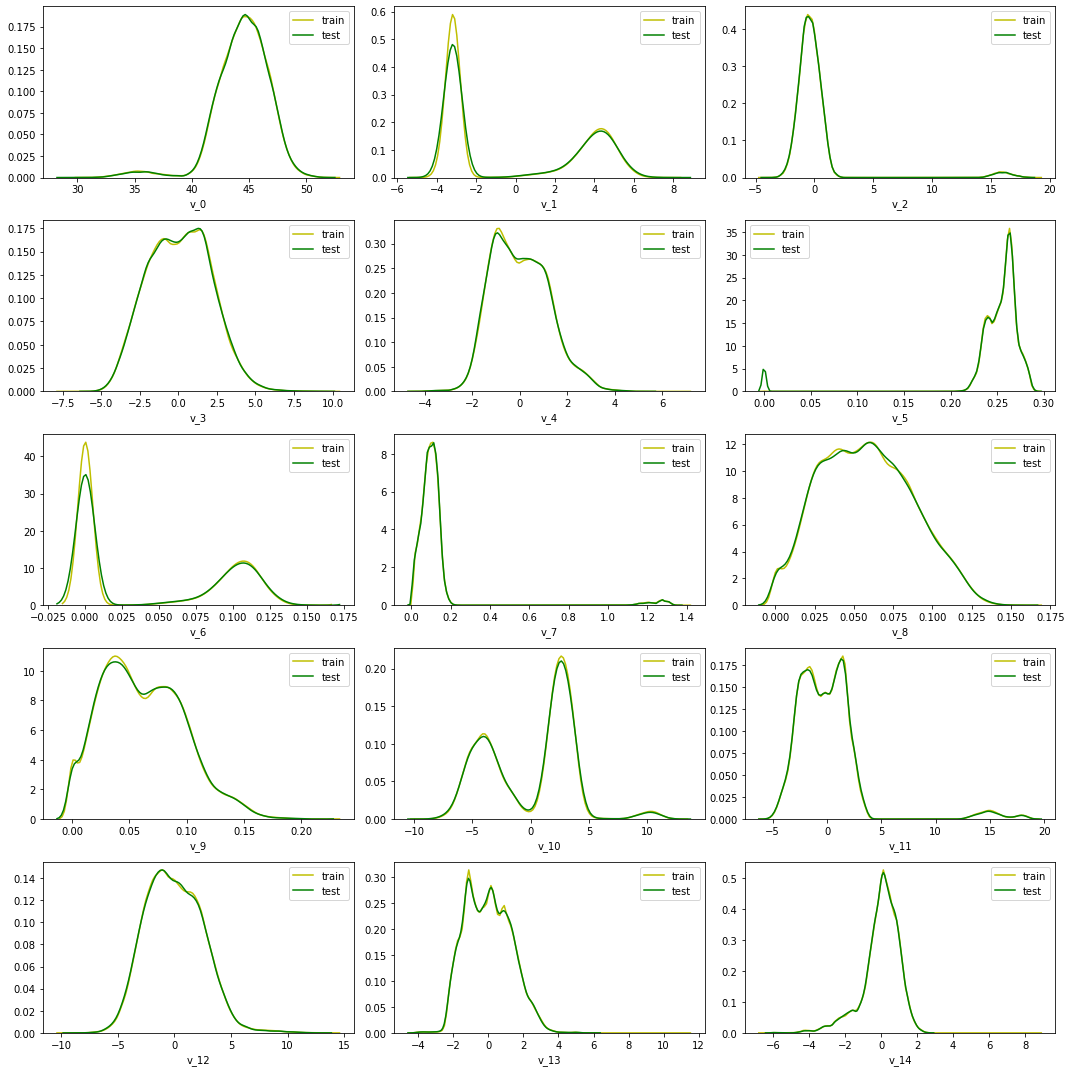

In [9]:
plt.figure()
plt.figure(figsize=(15, 15))
i = 1
for f in num_cols[2:]:
    plt.subplot(5, 3, i)
    i += 1
    sns.distplot(df[~df['price'].isnull()][f], label='train', color='y', hist=False)
    sns.distplot(df[df['price'].isnull()][f], label='test', color='g', hist=False)
plt.tight_layout()
plt.show()

单看几个n unique比较小的特征上面的price的均值的分布。可以发现regDate_year和kilometer的趋势变化很明显，这也对应了上面的相关性分布，这两个特征跟price的相关性都挺高。kilometer应该是被离散化过的，只保留了整数

<Figure size 432x288 with 0 Axes>

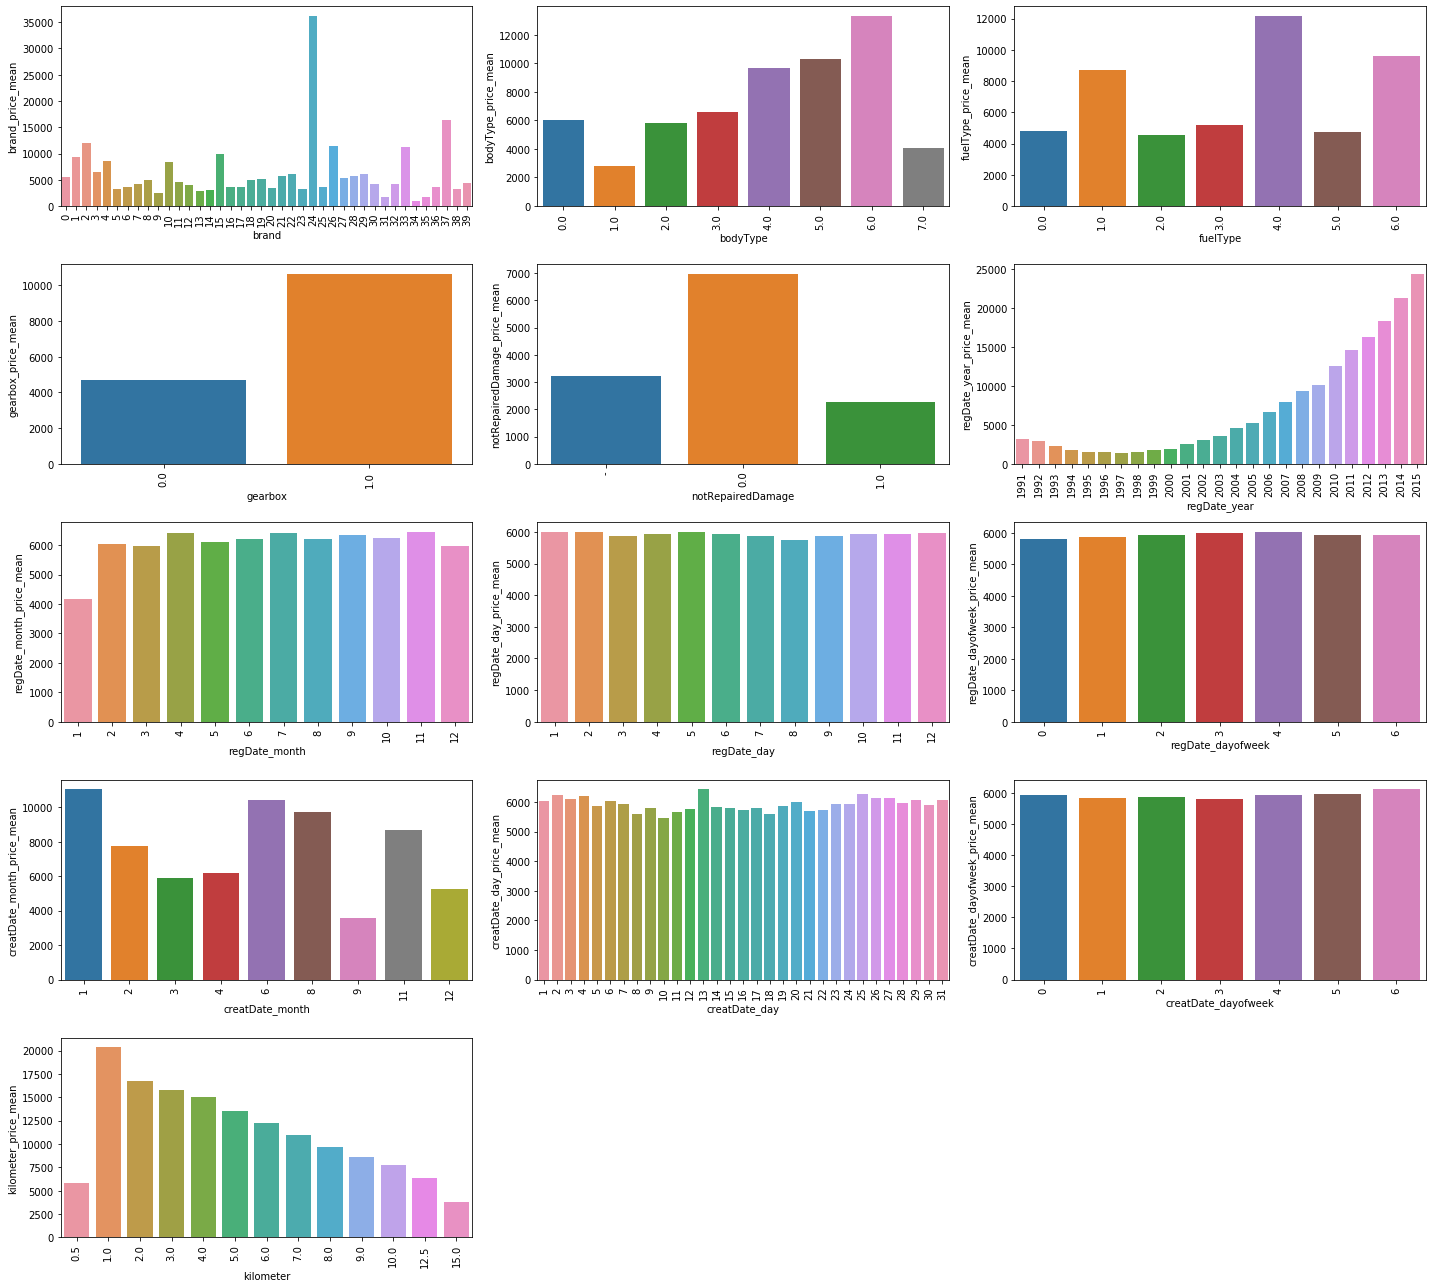

In [10]:
plt.figure()
plt.figure(figsize=(20, 18))
i = 1
for f in cate_cols + date_cols + num_cols:
    if df[f].nunique() <= 50:
        plt.subplot(5, 3, i)
        i += 1
        v = df[~df['price'].isnull()].groupby(f)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
        fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
plt.tight_layout()
plt.show()

下面简单做一做特征工程，然后开始训练模型，其实也就是实践了几个常用的套路

In [11]:
df['notRepairedDamage'] = df['notRepairedDamage'].astype('str').apply(lambda x: x if x != '-' else None).astype('float16')

In [12]:
from scipy.stats import entropy


feat_cols = []

### count编码
for f in tqdm([
    'regDate', 'creatDate', 'regDate_year',
    'model', 'brand', 'regionCode'
]):
    df[f + '_count'] = df[f].map(df[f].value_counts())
    feat_cols.append(f + '_count')

### 用数值特征对类别特征做统计刻画，随便挑了几个跟price相关性最高的匿名特征
for f1 in tqdm(['model', 'brand', 'regionCode']):
    g = df.groupby(f1, as_index=False)
    for f2 in tqdm(['v_0', 'v_3', 'v_8', 'v_12']):
        feat = g[f2].agg({
            '{}_{}_max'.format(f1, f2): 'max', '{}_{}_min'.format(f1, f2): 'min',
            '{}_{}_median'.format(f1, f2): 'median', '{}_{}_mean'.format(f1, f2): 'mean',
            '{}_{}_std'.format(f1, f2): 'std', '{}_{}_mad'.format(f1, f2): 'mad'
        })
        df = df.merge(feat, on=f1, how='left')
        feat_list = list(feat)
        feat_list.remove(f1)
        feat_cols.extend(feat_list)

### 类别特征的二阶交叉
for f_pair in tqdm([
    ['model', 'brand'], ['model', 'regionCode'], ['brand', 'regionCode']
]):
    ### 共现次数
    df['_'.join(f_pair) + '_count'] = df.groupby(f_pair)['SaleID'].transform('count')
    ### n unique、熵
    df = df.merge(df.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    df = df.merge(df.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    ### 比例偏好
    df['{}_in_{}_prop'.format(f_pair[0], f_pair[1])] = df['_'.join(f_pair) + '_count'] / df[f_pair[1] + '_count']
    df['{}_in_{}_prop'.format(f_pair[1], f_pair[0])] = df['_'.join(f_pair) + '_count'] / df[f_pair[0] + '_count']
    
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

100%|██████████| 3/3 [00:21<00:00,  7.17s/it]


In [13]:
from sklearn.model_selection import KFold


train_df = df[~df['price'].isnull()].reset_index(drop=True)
test_df = df[df['price'].isnull()].reset_index(drop=True)


### target encoding目标编码，回归场景相对来说做目标编码的选择更多，不仅可以做均值编码，还可以做标准差编码、中位数编码等
enc_cols = []
stats_default_dict = {
    'max': train_df['price'].max(),
    'min': train_df['price'].min(),
    'median': train_df['price'].median(),
    'mean': train_df['price'].mean(),
    'sum': train_df['price'].sum(),
    'std': train_df['price'].std(),
    'skew': train_df['price'].skew(),
    'kurt': train_df['price'].kurt(),
    'mad': train_df['price'].mad()
}
### 暂且选择这三种编码
enc_stats = ['mean', 'std', 'mad']
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
for f in tqdm(['model', 'brand', 'regionCode']):
    enc_dict = {}
    for stat in enc_stats:
        enc_dict['{}_target_{}'.format(f, stat)] = stat
        train_df['{}_target_{}'.format(f, stat)] = 0
        test_df['{}_target_{}'.format(f, stat)] = 0
        enc_cols.append('{}_target_{}'.format(f, stat))
    for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['price'])):
        trn_x, val_x = train_df.iloc[trn_idx].reset_index(drop=True), train_df.iloc[val_idx].reset_index(drop=True)
        enc_df = trn_x.groupby(f, as_index=False)['price'].agg(enc_dict)
        val_x = val_x[[f]].merge(enc_df, on=f, how='left')
        test_x = test_df[[f]].merge(enc_df, on=f, how='left')
        for stat in enc_stats:
            val_x['{}_target_{}'.format(f, stat)] = val_x['{}_target_{}'.format(f, stat)].fillna(stats_default_dict[stat])
            test_x['{}_target_{}'.format(f, stat)] = test_x['{}_target_{}'.format(f, stat)].fillna(stats_default_dict[stat])
            train_df.loc[val_idx, '{}_target_{}'.format(f, stat)] = val_x['{}_target_{}'.format(f, stat)].values
            test_df['{}_target_{}'.format(f, stat)] += test_x['{}_target_{}'.format(f, stat)].values / skf.n_splits


cols = cate_cols + date_cols + num_cols + feat_cols + enc_cols
sub = test_df[['SaleID']].copy()
test_df = test_df[cols]
labels = train_df['price'].values
train_df = train_df[cols]
print(train_df.shape)
train_df.head()

100%|██████████| 3/3 [00:26<00:00,  8.73s/it]
(150000, 140)


,name,model,brand,bodyType,fuelType,gearbox,notRepairedDamage,regionCode,regDate_year,regDate_month,regDate_day,regDate_dayofweek,creatDate_month,creatDate_day,creatDate_dayofweek,power,kilometer,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regDate_count,creatDate_count,regDate_year_count,model_count,brand_count,regionCode_count,model_v_0_max,model_v_0_min,model_v_0_median,model_v_0_mean,model_v_0_std,model_v_0_mad,model_v_3_max,model_v_3_min,model_v_3_median,model_v_3_mean,model_v_3_std,model_v_3_mad,model_v_8_max,model_v_8_min,model_v_8_median,model_v_8_mean,model_v_8_std,model_v_8_mad,model_v_12_max,model_v_12_min,model_v_12_median,model_v_12_mean,model_v_12_std,model_v_12_mad,brand_v_0_max,brand_v_0_min,brand_v_0_median,brand_v_0_mean,brand_v_0_std,brand_v_0_mad,brand_v_3_max,brand_v_3_min,brand_v_3_median,brand_v_3_mean,brand_v_3_std,brand_v_3_mad,brand_v_8_max,brand_v_8_min,brand_v_8_median,brand_v_8_mean,brand_v_8_std,brand_v_8_mad,brand_v_12_max,brand_v_12_min,brand_v_12_median,brand_v_12_mean,brand_v_12_std,brand_v_12_mad,regionCode_v_0_max,regionCode_v_0_min,regionCode_v_0_median,regionCode_v_0_mean,regionCode_v_0_std,regionCode_v_0_mad,regionCode_v_3_max,regionCode_v_3_min,regionCode_v_3_median,regionCode_v_3_mean,regionCode_v_3_std,regionCode_v_3_mad,regionCode_v_8_max,regionCode_v_8_min,regionCode_v_8_median,regionCode_v_8_mean,regionCode_v_8_std,regionCode_v_8_mad,regionCode_v_12_max,regionCode_v_12_min,regionCode_v_12_median,regionCode_v_12_mean,regionCode_v_12_std,regionCode_v_12_mad,model_brand_count,model_brand_nunique,model_brand_ent,brand_model_nunique,brand_model_ent,model_in_brand_prop,brand_in_model_prop,model_regionCode_count,model_regionCode_nunique,model_regionCode_ent,regionCode_model_nunique,regionCode_model_ent,model_in_regionCode_prop,regionCode_in_model_prop,brand_regionCode_count,brand_regionCode_nunique,brand_regionCode_ent,regionCode_brand_nunique,regionCode_brand_ent,brand_in_regionCode_prop,regionCode_in_brand_prop,model_target_mean,model_target_std,model_target_mad,brand_target_mean,brand_target_std,brand_target_mad,regionCode_target_mean,regionCode_target_std,regionCode_target_mad
0,736,30.0,6,1.0,0.0,0.0,0.0,1046,2004,4,2,4,4,4,0,60,12.5,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,100,7416,11899,3145.0,13719,47,46.342726,28.987024,42.918210,42.750103,2.039852,1.335433,7.375598,-3.651126,1.361821,1.119369,2.000747,1.685237,0.132452,0.000000,0.041461,0.044344,0.028413,0.023923,9.825077,-7.781645,-1.560370,-1.352894,2.292161,1.896074,49.216535,28.987024,43.518332,43.331114,2.282470,1.548165,9.121568,-5.433129,0.953054,0.733410,2.075349,1.700596,0.153849,0.0,0.045827,0.048987,0.029004,0.024024,11.778541,-8.293423,-1.411952,-1.041002,2.414547,1.953658,50.376809,33.511607,45.942332,45.445490,2.369732,1.507840,6.062231,-4.480148,-0.613237,-0.180360,2.049067,1.627380,0.132026,0.000000,0.063441,0.061578,0.029357,0.024186,6.353017,-4.362750,0.558707,0.699833,2.183664,1.773069,3145.0,1.0,0.000000,15,2.161420,0.229244,1.000000,1.0,1938.0,7.390204,27,3.062849,0.021277,0.000318,3,4553,8.091984,14,2.234541,0.063830,0.000219,2774.671714,3039.693856,2298.168884,3613.811755,4698.830289,3197.888310,8415.931034,10276.594200,6996.870392
1,2262,40.0,1,2.0,0.0,0.0,NaN,4366,2003,3,1,5,3,9,2,0,15.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,116,6937,12074,5911.0,18326,10,49.517245,33.708559,45.717711,45.594824,1.643656,1.135157,7.849033,-4.628179,-0.051705,0.065820,1.824363,1.539744,0.129159,0.000000,0.056804,0.056247,0.026896,0.022472,10.572566,-5.644524,0.735713,0.650309,2.031854,1.690149,50.735456,31.524342,46.038090,45.836925,2.083827,1.463073,9.201960,-5.411330,-0.611653,-0.448543,1.993718,1.670792,0.153444,0.0,0.064640,0.064518,0.029553,0.024529,12.973057,-6.589651,1.299017,1.201088,2.362357,1.941684

In [15]:
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time


oof = np.zeros(train_df.shape[0])
sub['price'] = 0
feat_imp_df = pd.DataFrame({'feat': cols, 'imp': 0})
skf = KFold(n_splits=5, shuffle=True, random_state=2020)
### 参数可以重新设置一下，天池这里面太慢了所以随便跑跑
clf = LGBMRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2020,
    metric=None
)
for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, labels)):
    print('--------------------- {} fold ---------------------'.format(i))
    t = time.time()
    trn_x, trn_y = train_df.iloc[trn_idx].reset_index(drop=True), labels[trn_idx]
    val_x, val_y = train_df.iloc[val_idx].reset_index(drop=True), labels[val_idx]
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        categorical_feature=cate_cols,
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=200
    )
    feat_imp_df['imp'] += clf.feature_importances_ / skf.n_splits
    oof[val_idx] = clf.predict(val_x)
    sub['price'] += clf.predict(test_df) / skf.n_splits
    print('val mse:', mean_squared_error(val_y, oof[val_idx]))
    print('runtime: {}\n'.format(time.time() - t))

mae = mean_absolute_error(labels, oof)
mse = mean_squared_error(labels, oof)
print('cv mae:', mae)
print('cv mse:', mse)
print('sub mean:', sub['price'].mean())
# sub.to_csv('sub_{}_{}_{}.csv'.format(mae, mse, sub['price'].mean()), index=False)


--------------------- 0 fold ---------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 652.728
[400]	valid_0's l1: 620.885
[600]	valid_0's l1: 602.933
[800]	valid_0's l1: 592.583
[1000]	valid_0's l1: 585.538
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 585.538
val mse:1816782.6944249014
runtime: 24.487508058547974

--------------------- 1 fold ---------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 648.739
[400]	valid_0's l1: 612.859
[600]	valid_0's l1: 594.671
[800]	valid_0's l1: 584.447
[1000]	valid_0's l1: 577.359
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 577.359
val mse:1452272.5909089479
runtime: 27.58725118637085

--------------------- 2 fold ---------------------
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l1: 660.524
[400]	valid_0's l1: 626.239
[600]	valid_0's l1: 610.116
[800]	valid_0's l1: 600.442
[1

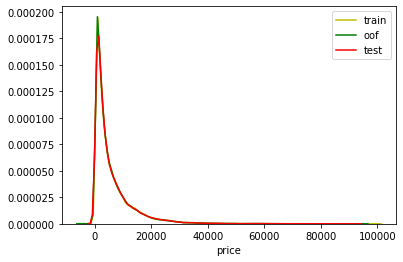

In [16]:
sns.distplot(labels, label='train', color='y', hist=False)
sns.distplot(oof, label='oof', color='g', hist=False)
sns.distplot(sub['price'], label='test', color='r', hist=False)

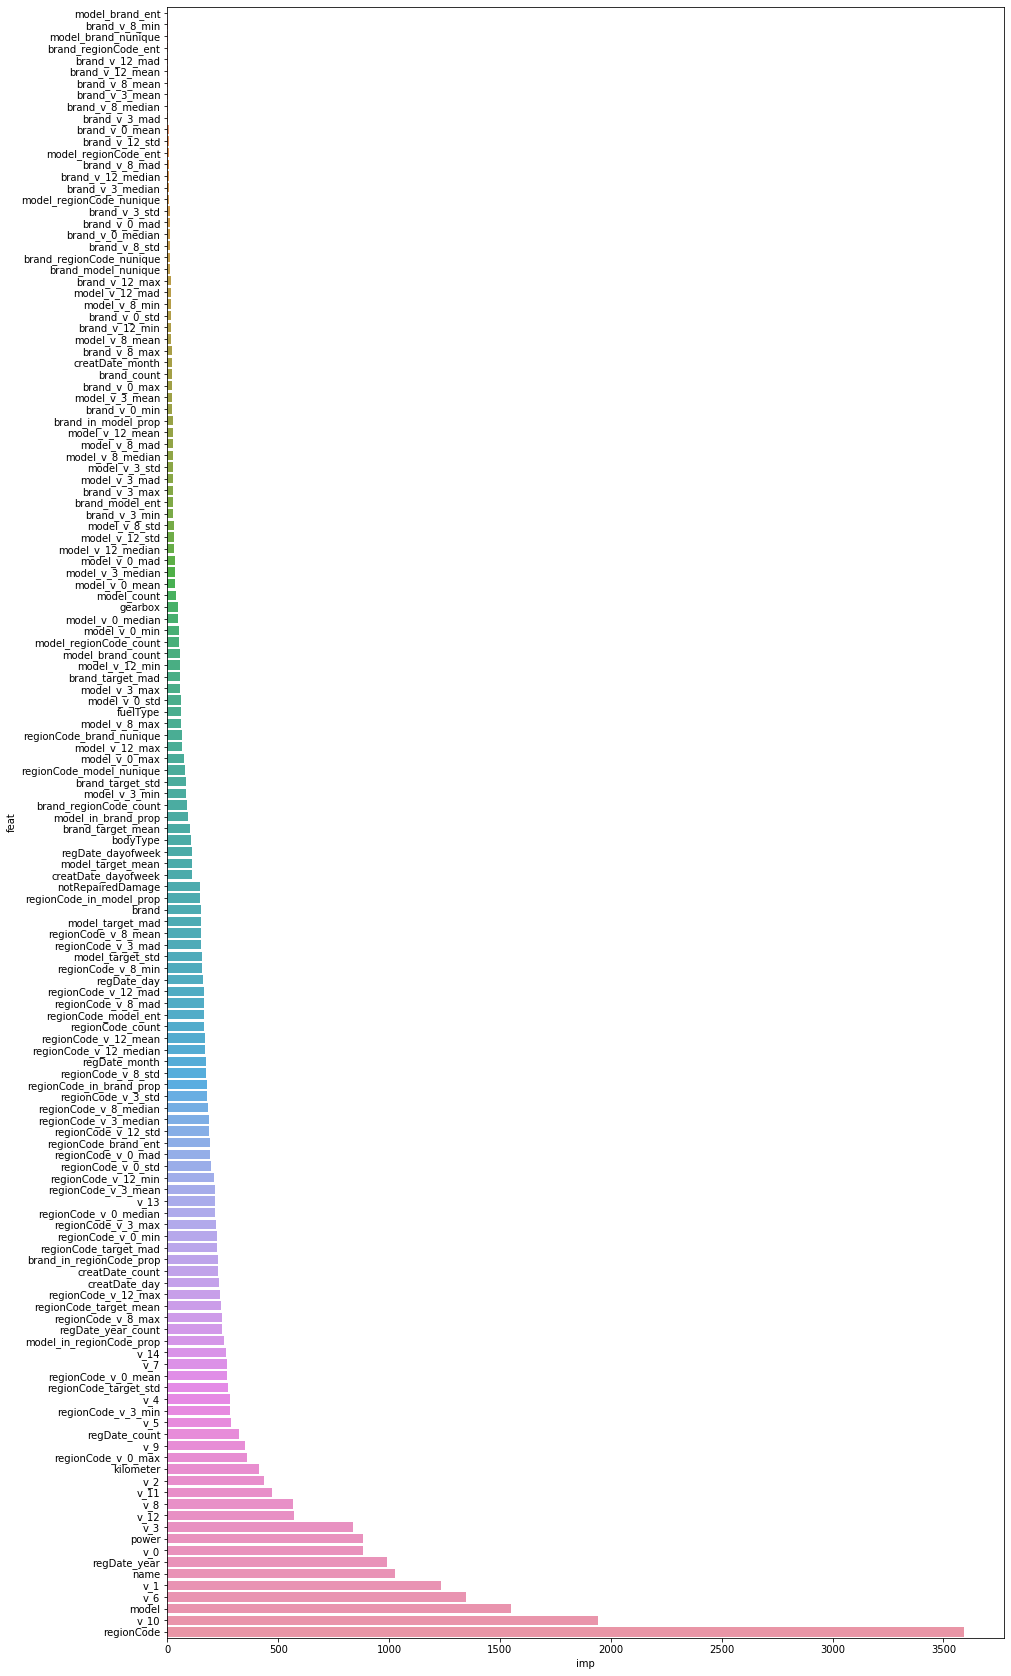

In [17]:
plt.figure(figsize=(15, 30))
feat_imp_df = feat_imp_df.sort_values('imp').reset_index(drop=True)
sns.barplot(x='imp', y='feat', data=feat_imp_df)